In [2]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os 
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D

In [4]:
def get_ordered_subdirectories(directory):
    entries = os.listdir(directory)
    subdirs = [os.path.join(directory, entry) 
               for entry in entries if os.path.isdir(os.path.join(directory, entry))]
    subdirs.sort()
    return subdirs

base = os.path.join(os.getcwd(),"ExperimentLogs")
ordered_subdirs = get_ordered_subdirectories(base)
last_exp = ordered_subdirs[0] # Acces latest experiment run 
print(last_exp)

C:\Users\zogaj\PycharmProjects\MA\ExperimentLogs\2024-09-27-16-29-16


In [5]:
def load_all_pickles(directory:str, model: str, graphtype: str) -> list:
    """
    Iterates over all pickle files in the specified directory and loads them.
    
    :param directory: Path to the directory containing the pickle files
    :return: A list of loaded objects from the pickle files
    """
    loaded_objects = []
    final_path = os.path.join(directory, model, graphtype)
    
    # Iterate over all files in the directory
    for filename in os.listdir(final_path):
        if filename[0] == "o": #  output_.pkl
            file_path = os.path.join(final_path, filename)
            with open(file_path, 'rb') as file:
                loaded_objects.append(pickle.load(file))
    
    return loaded_objects
 

## Store the results of all Model/Scenario Combinations 

In [6]:
# Graphtype must match with the names specified in config.py 
gcn_perfect = load_all_pickles(last_exp, "GCN", "perfect")
gat_perfect = load_all_pickles(last_exp, "GAT", "perfect")
sage_perfect = load_all_pickles(last_exp, "SAGE", "perfect")
XG_perfect = load_all_pickles(last_exp, "XGBOOST", "perfect")

gcn_com = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant")
gat_com = load_all_pickles(last_exp, "GAT", "community_relevant")
sage_com = load_all_pickles(last_exp, "SAGE", "community_relevant")
XG_com = load_all_pickles(last_exp, "XGBOOST", "community_relevant")

gcn_com_h = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant_heterophilic")
gat_com_h = load_all_pickles(last_exp, "GAT", "community_relevant_heterophilic")
sage_com_h = load_all_pickles(last_exp, "SAGE", "community_relevant_heterophilic")
XG_com_h = load_all_pickles(last_exp, "XGBOOST", "community_relevant_heterophilic")

gcn_com_r = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant_random")
gat_com_r = load_all_pickles(last_exp, "GAT", "community_relevant_random")
sage_com_r = load_all_pickles(last_exp, "SAGE", "community_relevant_random")
XG_com_r = load_all_pickles(last_exp, "XGBOOST", "community_relevant_random")

gcn_feat = load_all_pickles(directory=last_exp,model="GCN",graphtype="cluster_relevant")
gat_feat = load_all_pickles(last_exp, "GAT", "cluster_relevant")
sage_feat = load_all_pickles(last_exp, "SAGE", "cluster_relevant")
XG_feat = load_all_pickles(last_exp, "XGBOOST", "cluster_relevant")

gcn_feat_p = load_all_pickles(directory=last_exp,model="GCN",graphtype="non_seperated_cluster_relevant")
gat_feat_p = load_all_pickles(last_exp, "GAT", "non_seperated_cluster_relevant")
sage_feat_p = load_all_pickles(last_exp, "SAGE", "non_seperated_cluster_relevant")
XG_feat_p = load_all_pickles(last_exp, "XGBOOST", "non_seperated_cluster_relevant")

gcn_noise = load_all_pickles(directory=last_exp,model="GCN",graphtype="noise")
gat_noise = load_all_pickles(last_exp, "GAT", "noise")
sage_noise = load_all_pickles(last_exp, "SAGE", "noise")
XG_noise = load_all_pickles(last_exp, "XGBOOST", "noise")


In [54]:
package = np.array([[gcn_perfect, gcn_com, gcn_com_h, gcn_com_r, gcn_feat, gcn_feat_p, gcn_noise],  
                    [gat_perfect, gat_com, gat_com_h, gat_com_r, gat_feat, gat_feat_p, gat_noise],  
                    [sage_perfect, sage_com, sage_com_h,sage_com_r, sage_feat, sage_feat_p, sage_noise],  
                    [XG_perfect, XG_com, XG_com_h, XG_com_r, XG_feat, XG_feat_p, XG_noise]])

n_scenarios = 7
# package = np.array([[gcn_perfect, gat_perfect, sage_perfect, XG_perfect],
#                     [gcn_com, gat_com, sage_com, XG_com],
#                     [gcn_com_h, gat_com_h, sage_com_h, XG_com_h],
#                     #[gcn_com_r, gat_com_r, sage_com_r, XG_com_r],
#                     [gcn_feat, gat_feat, sage_feat, XG_feat],
#                     [gcn_feat_p, gat_feat_p, sage_feat_p, XG_feat_p],
#                     [gcn_noise, gat_noise, sage_noise, XG_noise]])

# n_scen = package.shape[0]
# package = package.T

# Plot 

In [55]:
def plot_with_confidence_interval(target, color, key="loss_track", empirical_CI=True, ax=None, percentiles=5):
    """
    Plots figure for one Scenario in specified axis.
    :param target: Results of the scenario.
    :param color: Color for scenario mapping.
    :param key: Key to extract values from target.
    :param empirical_CI: Boolean to use empirical confidence interval.
    :param ax: Axis object to plot on.
    :return: None
    """
    ys = np.array([lp[key] for lp in target])  # loss-values @ epoch
    final_epoch = np.mean([lp["final_epoch"] for lp in target])

    mean_ys = np.mean(ys, axis=0)
    std_ys = np.sqrt(np.var(ys, axis=0))

    if empirical_CI:
        ci_lower = np.percentile(ys, percentiles, axis=0)
        ci_upper = np.percentile(ys, (100-percentiles), axis=0)
    else:
        ci_upper = mean_ys + 1.96 * std_ys
        ci_lower = mean_ys - 1.96 * std_ys

    x = np.arange(len(mean_ys))

    ax.plot(x, mean_ys, color=color)
    ax.fill_between(x, ci_lower, ci_upper, color=color, alpha=0.2)
    ax.axvline(x=final_epoch, color=color, linestyle='--')
    
    return final_epoch

### Loss Curves

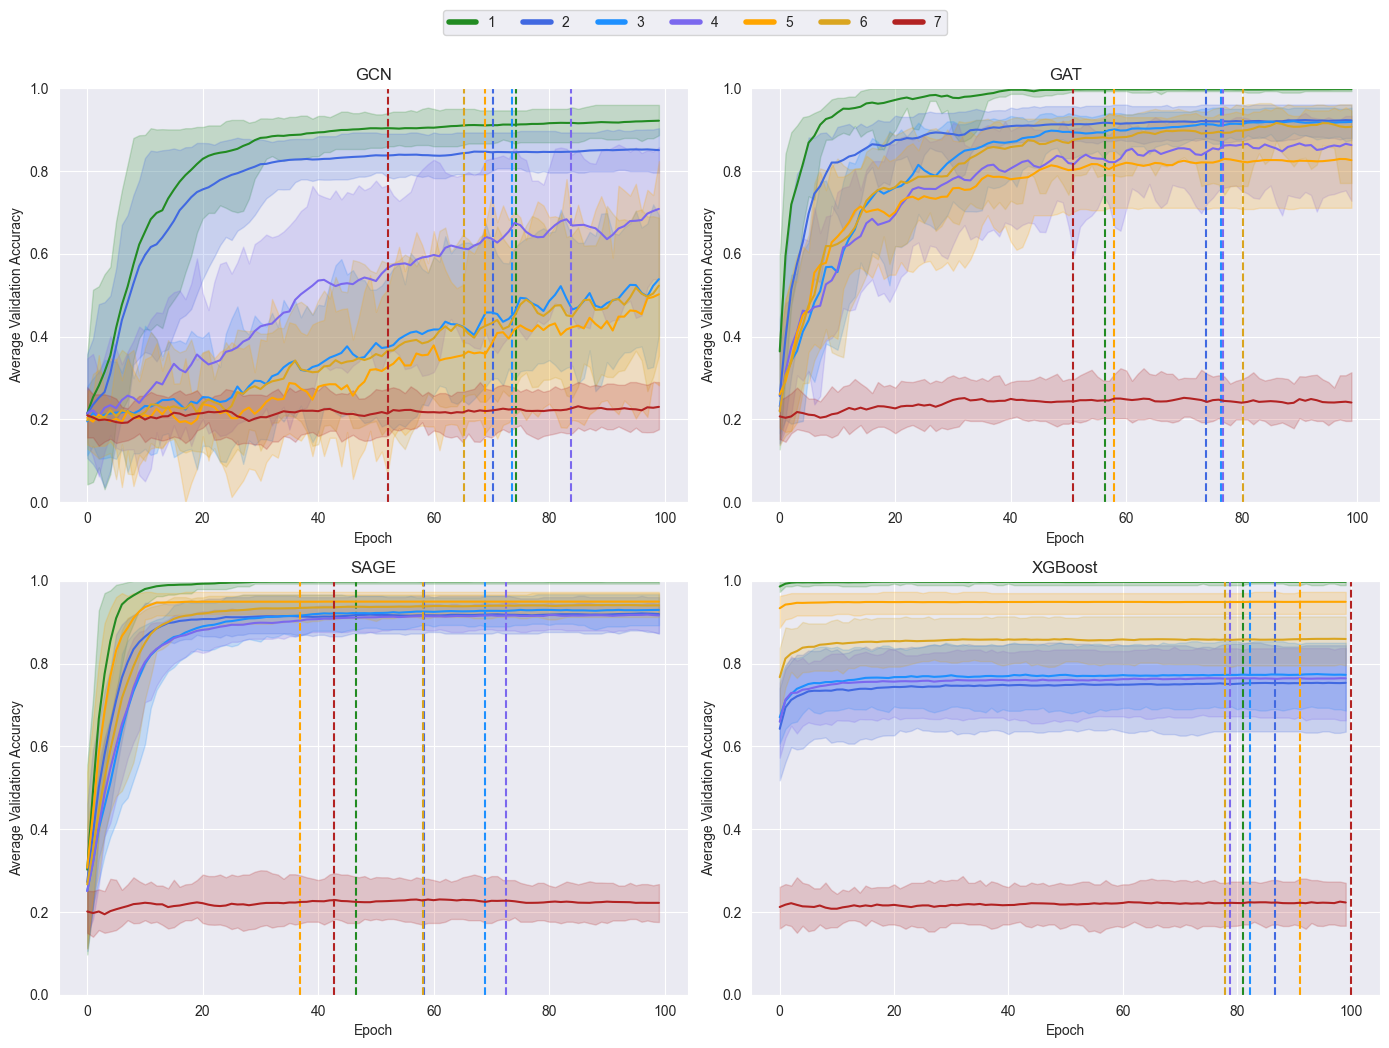

array([[ 74.27,  70.2 ,  73.63,  83.73,  68.8 ,  65.3 ,  52.1 ],
       [ 56.3 ,  73.9 ,  76.33,  76.7 ,  57.8 ,  80.23,  50.87],
       [ 46.47,  58.3 ,  68.83,  72.5 ,  36.9 ,  58.17,  42.7 ],
       [ 81.07,  86.63,  82.23,  78.83,  90.93,  77.97, 100.  ]])

In [56]:
#l_o_a = "loss_track"  
l_o_a = "val_acc_track"

arch = ["GCN", "GAT", "SAGE", "XGBoost"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
axes = axes.flatten()  

early_stops = np.zeros((4, n_scenarios))

labels = np.arange(n_scenarios) + 1
colors = ["forestgreen", "royalblue", "dodgerblue", "mediumslateblue", "orange", "goldenrod", "firebrick"]


for i, (model, ax) in enumerate(zip(package, axes)):
    for j, (target, label, color) in enumerate(zip(model, labels, colors)):
        early_stops[i, j] = plot_with_confidence_interval(target, color, key=l_o_a,
                                                          empirical_CI=True, ax=ax, percentiles=5)
        ax.plot([], [], color=color, label=label)  # Adding to legend

    ax.set_xlabel('Epoch')
    if l_o_a == "loss_track":
        ax.set_ylabel('Average Loss')
    else:
        ax.set_ylabel('Average Validation Accuracy')
        
    ax.set_ylim(0, 1)
    ax.set_title(f'{arch[i]}')

handles = [Line2D([0], [0], color=color, lw=4) for color in colors]
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize='medium')

plt.tight_layout()
plt.show()
np.round(early_stops, 2)

In [57]:
# Loss/val_acc tracks appear very similar for com_random across all 4 models
# np.mean([r["test_accuracy"] for r in gat_com_r], axis=0) == np.mean([r["test_accuracy"] for r in sage_com_r], axis=0)
print(np.round(np.mean([r["test_accuracy"] for r in gcn_perfect]), 3))
print(np.round(np.mean([r["test_accuracy"] for r in sage_com]),3))

0.919
0.924


### Test accs 

In [58]:
mus = np.zeros((4, n_scenarios))  # models (i) x scenarios (j)
sigs = np.zeros((4, n_scenarios))  

for i, model in enumerate(package): #[[GCN,...], [GAT,...],...]
    for j, scen in enumerate(model): # [1, 2, 3, 4, 5, 6, 7]
        accs = [acc["test_accuracy"] for acc in scen]
        
        mus[i, j] += np.round(np.mean(accs), 3)
        sigs[i, j] += np.round(np.sqrt(np.var(accs)), 3)


result = np.array([[f'{a} ({b})' for a, b in zip(row_A, row_B)]
                   for row_A, row_B in zip(mus, sigs)])        

result = pd.DataFrame(result,
                      index=["GCN", "GAT","SAGE","XGBoost"],
                      columns=["Perfect", "com", "com_h",
                               "com_r",
                               "feat", "feat_p", "noise"])
result


,Perfect,com,com_h,com_r,feat,feat_p,noise
GCN,0.919 (0.019),0.859 (0.022),0.425 (0.155),0.638 (0.174),0.376 (0.199),0.4 (0.157),0.213 (0.027)
GAT,0.997 (0.003),0.928 (0.018),0.893 (0.038),0.853 (0.069),0.799 (0.076),0.877 (0.064),0.247 (0.032)
SAGE,0.998 (0.002),0.924 (0.018),0.918 (0.023),0.915 (0.014),0.939 (0.016),0.929 (0.02),0.244 (0.029)
XGBoost,0.998 (0.002),0.758 (0.064),0.758 (0.05),0.765 (0.038),0.939 (0.017),0.844 (0.044),0.226 (0.027)


### Hypothesis: If feature-clusters are too far apart, it becomes harder to embed them ? 

In [ ]:
def MCR_plot(target, color, ax=None):
        ys = [lp["test_accuracy"] for lp in target] 
        r_avg = np.cumsum(ys) / np.arange(1, len(ys) + 1)
        x = np.arange(len(ys))
        ax.plot(x, r_avg, color=color)

arch = ["GCN", "GAT", "SAGE", "XGBoost"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
axes = axes.flatten()  

labels = np.arange(n_scenarios) + 1
colors = ["forestgreen", "royalblue", "dodgerblue", "mediumslateblue", "orange", "goldenrod", "firebrick"]


for i, (model, ax) in enumerate(zip(package, axes)):
    for j, (target, label, color) in enumerate(zip(model, labels, colors)):
        early_stops[i, j] = MCR_plot(target, color, ax=ax)
        ax.plot([], [], color=color, label=label)  # Adding to legend

    ax.set_xlabel('Epoch')
    ax.set_ylabel('MC Average: Test accuracy')
    
    ax.set_title(f'{arch[i]}')

handles = [Line2D([0], [0], color=color, lw=4) for color in colors]
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize='medium')

plt.tight_layout()
plt.show()
    

# Graph Characteristics 

In [18]:
def load_all_pickles_char(directory:str, graphtype: str) -> list:
    """
    Iterates over all pickle files in the specified directory and loads them.
    
    :param directory: Path to the directory containing the pickle files
    :return: A list of loaded objects from the pickle files
    """
    loaded_objects = []
    final_path = os.path.join(directory, "GraphCharacteristics", graphtype)
    
    # Iterate over all files in the directory
    for filename in os.listdir(final_path):
        if filename[0] == "o": #  output_.pkl
            file_path = os.path.join(final_path, filename)
            with open(file_path, 'rb') as file:
                loaded_objects.append(pickle.load(file))
    
    return loaded_objects
 

In [19]:
perfect = load_all_pickles_char(directory=last_exp,graphtype="perfect")
community_relevant = load_all_pickles_char(directory=last_exp,graphtype="community_relevant")
community_relevant_h = load_all_pickles_char(directory=last_exp,graphtype="community_relevant_heterophilic")
community_relevant_r = load_all_pickles_char(directory=last_exp,graphtype="community_relevant_random")
cluster_relevant = load_all_pickles_char(directory=last_exp,graphtype="cluster_relevant")
cluster_relevant_p = load_all_pickles_char(directory=last_exp,graphtype="non_seperated_cluster_relevant")
noise = load_all_pickles_char(directory=last_exp,graphtype="noise")

package2 = [perfect, community_relevant, community_relevant_h,
            cluster_relevant, cluster_relevant_p, noise]

In [15]:
# def plot_kde(target: dict, color:str, label:str, metric="h", filter=False):
#     if metric == "h":
#         y = np.array([lp["h_hat"] for lp in target])  # vector of values 
#     if metric == "l":
#         y = np.array([lp["wilks_lambda"][0] for lp in target])
#         ps = np.array([True if p["wilks_lambda"][1] <= .05 else False for p in target])
#     if filter:
#         y = y[ps]
#         print(label,": ", 30 - sum(ps))
#         
#     avg_y = np.mean(y)
#     sns.kdeplot(y, color=color, label=label, fill=True) 
#     plt.axvline(x=avg_y, color=color, linestyle='--')


In [23]:
mus = np.zeros((2, n_scenarios))  
sigs = np.zeros((2, n_scenarios))  

for k, m in enumerate(["h_hat", "wilks_lambda"]):
    for i, s in enumerate([perfect, community_relevant, community_relevant_h,community_relevant_r,
                          cluster_relevant, cluster_relevant_p, noise]): 
        y = [acc[m] for j, acc in enumerate(s)]
        accuracy = np.mean(y)
        sd_accuracy = np.var(y)
        mus[k, i] += np.round(accuracy, 3)
        sigs[k, i] += np.round(np.sqrt(sd_accuracy), 3)
    
    
    result = np.array([[f'{a} ({b})' for a, b in zip(row_A, row_B)] for row_A, row_B in zip(mus, sigs)])        
    result = pd.DataFrame(result,
                          index=["h", "L"],
                          columns=["Perfect", "com", "com_h" ,"com_r" ,"feat", "feat_p", "noise"])

result

,Perfect,com,com_h,com_r,feat,feat_p,noise
h,0.685 (0.002),0.59 (0.016),0.0 (0.0),0.0 (0.0),0.0 (0.0),0.0 (0.0),0.003 (0.001)
L,0.036 (0.045),0.265 (0.275),0.279 (0.285),0.283 (0.29),0.104 (0.107),0.232 (0.239),0.575 (0.44)


In [77]:
Y = np.zeros((4,7,30))

for i, model in enumerate(package): #[[GCN,...], [GAT,...],...]
    for j, scen in enumerate(model): # [1, 2, 3, 4, 5, 6, 7]
        accs = [acc["test_accuracy"] for acc in scen]
        Y[i,j,:] = accs
        

In [103]:
x1 = np.array(([g["h_hat"] for g in perfect],
          [g["h_hat"] for g in community_relevant],
          [g["h_hat"] for g in community_relevant_h],
          [g["h_hat"] for g in community_relevant_r],
          [g["h_hat"] for g in cluster_relevant],
          [g["h_hat"] for g in cluster_relevant_p],
          [g["h_hat"] for g in noise])).flatten().reshape(210)

x2 = np.array(([g["wilks_lambda"][0] for g in perfect],
          [g["wilks_lambda"][0] for g in community_relevant],
          [g["wilks_lambda"][0] for g in community_relevant_h],
          [g["wilks_lambda"][0] for g in community_relevant_r],
          [g["wilks_lambda"][0] for g in cluster_relevant],
          [g["wilks_lambda"][0] for g in cluster_relevant_p],
          [g["wilks_lambda"][0] for g in noise])).flatten().reshape(210)

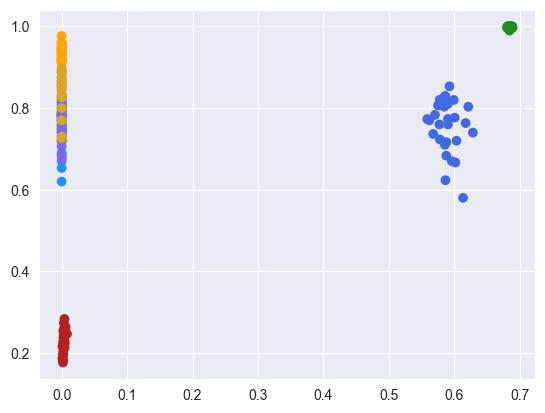

In [106]:
colors = np.repeat(["forestgreen", "royalblue", "dodgerblue", "mediumslateblue", "orange", "goldenrod", "firebrick"], 30)
plt.scatter(x1,Y[3,:,:].flatten().reshape(210), color=colors)
plt.show()

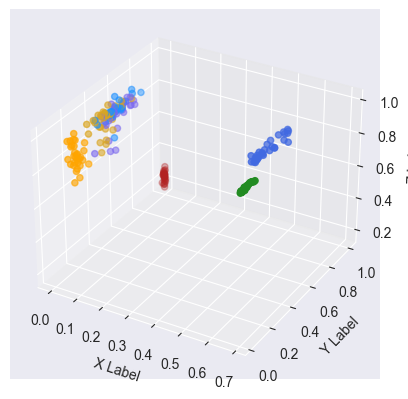

In [105]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, x2, Y[1,:,:].flatten().reshape(210), color=colors)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [ ]:
# fig, axes = plt.subplots(2, 1, figsize=(10, 8))
# 
# for idx, m in enumerate(["h_hat", "wilks_lambda"]):
#     cumavg = lambda x: np.cumsum(x) / np.arange(1, len(x) + 1)
#     M = np.array([[lp[m] for lp in scen] for scen in package2])
#     M = np.apply_along_axis(cumavg, 1, M)  
# 
#     for i in range(M.shape[0]):
#         axes[idx].plot(np.arange(M.shape[1]), M[i], color=colors[i]) # x, y, col
# 
#     axes[idx].set_title(f'Cumulative Average of {m}')
#     axes[idx].set_xlabel('Time')
#     axes[idx].set_ylabel(f'{m} values')
# 
# 
# lines = [plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(n_scenarios)]
# fig.legend(lines, [f'{label}' for label in labels], loc='upper center', ncol=n_scenarios)
# 
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend at the top
# 
# # Show the plots
# plt.show()